# Bus Cost Refactor
## overall imports and data sources

In [1]:
import pandas as pd
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 100)

In [2]:
# Old script imports
from fta_data_cleaner import *
from dgs_data_cleaner import *
from tircp_data_cleaner import *

In [3]:
# updated Script imports for bus cost utils


In [4]:
#immutable GCS path
# save to bus cost utils
GCS_PATH = "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/"

In [5]:
# links to all Raw Data
fta_raw = pd.read_csv(f"{GCS_PATH}raw_data-analyses_bus_procurement_cost_fta_press_release_data_csv.csv")
tircp_raw = pd.read_excel(f"{GCS_PATH}raw_TIRCP Tracking Sheets 2_1-10-2024.xlsx", sheet_name="Project Tracking")
dgs17b_raw = pd.read_excel(f"{GCS_PATH}raw_17b compiled.xlsx", sheet_name = "Usage Report Template")
dgs17c_raw = pd.read_excel(f"{GCS_PATH}raw_17c compiled-Proterra Compiled Contract Usage Report .xlsx", sheet_name = "Proterra ")

/opt/conda/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


# Functions to Save
for new `bus_cost_utils.py` script

## save to bus_cost_utils.py
for everything to use from

In [6]:
# NEW FUNCTION
# move this to bus_cost_utils
def bus_min_max_summary(data:pd.DataFrame, col1:str, col_list=["transit_agency",
                                                     "total_agg_cost",
                                                     "total_bus_count",
                                                     "new_cost_per_bus"]):
    """
    function to display min/max of specific column in aggregated bus df.
    
    """
    
    return display(
        Markdown(f"**Max {col1}**"),
        data[data[col1] == data[col1].max()][col_list],
        Markdown(f"**Min {col1}**"),
        data[data[col1] == data[col1].min()][col_list]
                  )
        


In [7]:
# NEW PROP FINDER
def new_prop_finder(description: str) -> str:
    """
    function that matches keywords from each propulsion type list against the item description col, returns a standardized prop type
    now includes variable that make description input lowercase.
    to be used with .assign()
    """

    BEB_list = [
        "battery electric",
        "BEBs paratransit buses"
    ]

    cng_list = [
        "cng",
        "compressed natural gas"    
    ]

    electric_list = [
        "electric buses",
        "electric commuter",
        "electric",
    ]

    FCEB_list = [
        "fuel cell",
        "hydrogen",
        #"fuel cell electric",
        #"hydrogen fuel cell",
        #"fuel cell electric bus",
        #"hydrogen electric bus",
    ]

    # low emission (hybrid)
    hybrid_list = [
        #"diesel electric hybrids",
        #"diesel-electric hybrids",
        #"hybrid electric",
        #"hybrid electric buses",
        #"hybrid electrics",
        "hybrids",
        "hybrid",
    ]

    # low emission (propane)
    propane_list = [
        #"propane buses",
        #"propaned powered vehicles",
        "propane",
    ]

    mix_beb_list = [
        "2 BEBs and 4 hydrogen fuel cell buses",
    ]

    mix_lowe_list = [
        "diesel and gas",
    ]

    mix_zero_low_list = [
        "15 electic, 16 hybrid",
        "4 fuel cell / 3 CNG",
        "estimated-cutaway vans (PM- award will not fund 68 buses",
        "1:CNGbus ;2 cutaway CNG buses",
    ]

    zero_e_list = [
        #"zero emission buses",
        #"zero emission electric",
        #"zero emission vehicles",
        "zero-emission",
        "zero emission",
    ]

    item_description = description.lower().replace("‐", " ").strip()

    if any(word in item_description for word in BEB_list) and not any(
        word in item_description for word in ["diesel", "hybrid", "fuel cell"]
    ):
        return "BEB"

    elif any(word in item_description for word in FCEB_list):
        return "FCEB"

    elif any(word in item_description for word in hybrid_list):
        return "low emission (hybrid)"

    elif any(word in item_description for word in mix_beb_list):
        return "mix (BEB and FCEB)"

    elif any(word in item_description for word in mix_lowe_list):
        return "mix (low emission)"

    elif any(word in item_description for word in mix_zero_low_list):
        return "mix (zero and low emission)"

    elif any(word in item_description for word in zero_e_list):
        return "zero-emission bus (not specified)"

    elif any(word in item_description for word in propane_list):
        return "low emission (propane)"

    elif any(word in item_description for word in electric_list):
        return "electric (not specified)"
    
    elif any(word in item_description for word in cng_list):
        return "CNG"

    else:
        return "not specified"

In [8]:
def new_bus_size_finder(description: str) -> str:
    """
    Similar to prop_type_find, matches keywords to item description col and return standardized bus size type.
    now includes variable that make description input lowercase.
    To be used with .assign()
    """

    articulated_list = [
        "60 foot",
        "articulated",
    ]

    standard_bus_list = [
        "30 foot",
        "35 foot",
        "40 foot",
        "40ft",
        "45 foot",
        "standard",
    ]

    cutaway_list = [
        "cutaway",
    ]

    other_bus_size_list = ["feeder bus"]

    otr_bus_list = [
        "coach style",
        "over the road",
    ]

    item_description = description.lower().replace("-", " ").strip()

    if any(word in item_description for word in articulated_list):
        return "articulated"

    elif any(word in item_description for word in standard_bus_list):
        return "standard/conventional (30ft-45ft)"

    elif any(word in item_description for word in cutaway_list):
        return "cutaway"

    elif any(word in item_description for word in otr_bus_list):
        return "over-the-road"

    elif any(word in item_description for word in other_bus_size_list):
        return "other"

    else:
        return "not specified"

In [9]:
def project_type_finder(description: str) -> str:
    """
    function to match keywords to project description col to identify projects that only have bus procurement.
    used to identify projects into diffferent categories: bus only, bus + others, no bus procurement.
    use with .assign() to get a new col.
    """
    bus_list =[
        "bus",
        "transit vehicles",# for fta list
        "cutaway vehicles",# for fta list
        "zero-emission vehicles", # for tircp list
        "zero emission vehicles",
        "zero‐emissions vans",
        "hybrid-electric vehicles",
        "battery-electric vehicles",
        "buy new replacement vehicles", # specific string for fta list
    ]
    
    exclude_list =[
        "facility",
        #"station",
        "stops",
        "installation",
        "depot",
        "construct",
        "infrastructure",
        "signal priority",
        "improvements",
        "build",
        "chargers",
        "charging equipment",
        "install",
        "rail",
        "garage",
        "facilities",
        "bus washing system",
        "build a regional transit hub" # specific string needed for fta list
        #"associated infrastructure" may need to look at what is associated infrastructure is for ZEB 
        
    ]
    proj_description = description.lower().strip()

    if any(word in proj_description for word in bus_list) and not any(
        word in proj_description for word in exclude_list
    ):
        return "bus only"
    
    elif any(word in proj_description for word in exclude_list) and not any(
        word in proj_description for word in bus_list
    ):
        return "non-bus components"
    
    elif any(word in proj_description for word in exclude_list) and any(
        word in proj_description for word in bus_list
    ):
        return "includes bus and non-bus components"
    
    else:
        return "needs review"

In [10]:
def col_row_updater(df: pd.DataFrame, col1: str, val1, col2: str, new_val):
    """
    function used to update values at specificed columns and row value.
    """
    df.loc[df[col1] == val1, col2] = new_val
    
    return

In [11]:
# to new bus_cost_util
def outlier_flag(col):
    """
    function to flag outlier rows. use with .apply()
    """
    
    return col <= -3 or col >= 3

from scipy.stats import zscore
def new_cpb_aggregate(df: pd.DataFrame, column="transit_agency") -> pd.DataFrame:
    """
    function to aggregate compiled data by different categories:
        "transit agency", 
        "propulsion type", 
        "bus_size_type",
        "new_project_type"
    aggregate on columns:
        "project_title"
        "ppno"
        "total_cost"
        "bus_count"
        
    Then, cost per bus is calculated AFTER the aggregation.
    """
    df_agg = (
        df.groupby(column)
        .agg(
            total_project_count=("project_title", "count"),
            total_project_count_ppno=("ppno", "count"),
            total_agg_cost=("total_cost", "sum"),
            total_bus_count=("bus_count", "sum"),
            #new_prop_type=("prop_type","max")
        )
        .reset_index()
    )
    df_agg["new_cost_per_bus"] = (df_agg["total_agg_cost"] / df_agg["total_bus_count"]).astype("int64")
    
    #calculate zscore
    df_agg["new_zscore_cost_per_bus"] = zscore(df_agg["new_cost_per_bus"])
    
    #flag outliers
    df_agg["new_is_cpb_outlier?"] = df_agg["new_zscore_cost_per_bus"].apply(outlier_flag)
    
    return df_agg

## save to analysis notebook
chart functions should stay in the analysis notebook since the charts only exist in the analysis notebook


In [12]:
def make_chart(y_col: str, title: str, data: pd.DataFrame, x_col: str):
    """
    function to create chart. sorts values by y_col ascending."""
    
    data.sort_values(by=y_col, ascending=False).head(10).plot(
        x=x_col, y=y_col, kind="bar", color="skyblue"
    )
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.ticklabel_format(style="plain", axis="y")
    plt.show()

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def dist_curve(
    df: pd.DataFrame,
    mean: str,
    std: str,
    title: str,
    xlabel: str,
):
    """
    function to make distribution curve. uses the "cpb" column of the df.
    """
    sns.histplot(df["cost_per_bus"], kde=True, color="skyblue", bins=20)
    # mean line
    plt.axvline(
        mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
    )
    # mean+1std
    plt.axvline(
        mean + std,
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Standard Deviation: ${std:,.2f}",
    )
    plt.axvline(mean - std, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 2), color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 3), color="green", linestyle="dashed", linewidth=2)

    plt.title(title + " with Mean and Standard Deviation")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

    # Turn off scientific notation on x-axis?
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.legend()
    plt.show()

    return


# Chagnes to current grant type scripts


## FTA Script

In [14]:
# FTA
# copied over 6/25/2024
import numpy as np
import pandas as pd
import shared_utils
from calitp_data_analysis.sql import to_snakecase
from bus_cost_utils import *
# from dgs_data_cleaner import new_bus_size_finder, new_prop_finder, project_type_checker
#from tircp_data_cleaner import col_row_updater

def col_splitter(
    df: pd.DataFrame, 
    col_to_split: str, 
    new_col1: str, 
    new_col2: str, 
    split_char: str
)-> pd.DataFrame:
    """
    function to split a column into 2 columns by specific character.
    ex. split 100(beb) to "100" & "(beb)"
    """
    df[[new_col1, new_col2]] = df[col_to_split].str.split(
        pat=split_char, n=1, expand=True
    )

    df[new_col2] = df[new_col2].str.replace(")", "")

    return df

def fta_agg_bus_only(df: pd.DataFrame) -> pd.DataFrame:
    """
    filters FTA data to only show projects with bus procurement (bus count > 0).
    then filters projects for new_project_type = bus only
    then aggregates
    """
    df1 = df[(df["bus_count"] > 0) & (df["new_project_type"] == "bus only")]

    df2 = (
        df1.groupby(
            [
                "project_sponsor",
                "project_title",
                "new_prop_type_finder",
                "new_bus_size_type",
                "description",
                "new_project_type"
            ]
        )
        .agg(
            {
                "funding": "sum",
                "bus_count": "sum",
            }
        )
        .reset_index()
    )

    return df2

def clean_fta_columns() -> pd.DataFrame:
    """
    Main function to clean FTA data. Reads in data, changes datatypes, change specific values.
    """
    # params
    
    file = "raw_data-analyses_bus_procurement_cost_fta_press_release_data_csv.csv"

    # read in data
    df = pd.read_csv(f"{GCS_PATH}{file}")

    # snakecase df
    df = to_snakecase(df)

    # clean funding values
    df["funding"] = (
        df["funding"]
        .str.replace("$", "")
        .str.replace(",", "")
        .str.strip()
    )

    # rename initial propulsion type col to propulsion category
    df = df.rename(columns={"propulsion_type": "prosulsion_category"})

    # splitting `approx_#_of_buses` col to get bus count
    df1 = col_splitter(df, "approx_#_of_buses", "bus_count", "extract_prop_type", "(")

    # assign new columns via new_prop_finder and new_bus_size_finder
    df2 = df1.assign(
        new_prop_type_finder=df1["description"].apply(new_prop_finder),
        new_bus_size_type=df1["description"].apply(new_bus_size_finder),
        new_project_type=df1["description"].apply(project_type_finder)
    )

    # cleaning specific values
    col_row_updater(df2, "funding", "7443765", "bus_count", 56)
    col_row_updater(df2, "funding", "17532900", "bus_count", 12)
    col_row_updater(df2, "funding", "40402548", "new_prop_type_finder", "CNG")
    col_row_updater(df2, "funding", "30890413", "new_prop_type_finder", "mix (zero and low emission)")
    col_row_updater(df2, "funding", "29331665", "new_prop_type_finder", "mix (zero and low emission)")
    col_row_updater(df2, "funding", "7598425", "new_prop_type_finder", "mix (zero and low emission)")
    col_row_updater(df2, "funding", "7443765", "new_prop_type_finder", "mix (zero and low emission)")
    col_row_updater(df2, "funding", "3303600", "new_prop_type_finder", "mix (diesel and gas)")
    col_row_updater(df2, "funding", "2063160", "new_prop_type_finder", "low emission (hybrid)")
    col_row_updater(df2, "funding", "1760000", "new_prop_type_finder", "low emission (propane)")
    col_row_updater(df2, "funding", "1006750", "new_prop_type_finder", "ethanol")
    col_row_updater(df2, "funding", "723171", "new_prop_type_finder", "low emission (propane)")
    col_row_updater(df2, "funding", "23280546", "new_prop_type_finder", "BEB")

    # update data types
    update_cols = ["funding", "bus_count"]

    df2[update_cols] = df2[update_cols].astype("int64")

    return df2

#if __name__ == "__main__":

    # initial df (all projects)
#    all_projects = clean_fta_columns()

    # projects with bus count > 0 only.
#    just_bus = fta_agg_bus_only(all_projects)

    # export both DFs
#    all_projects.to_parquet(f"{GCS_PATH}clean_fta_all_projects.parquet")
#    just_bus.to_parquet(f"{GCS_PATH}clean_fta_bus_only.parquet")

## TIRCP script

In [15]:
# TIRCP
## copied over 6/25/24
import numpy as np
import pandas as pd
import shared_utils
from calitp_data_analysis.sql import to_snakecase
from bus_cost_utils import *

def clean_tircp_columns() -> pd.DataFrame:
    """
    main function that reads in and cleans TIRCP data.
    """
    
    file_name = "raw_TIRCP Tracking Sheets 2_1-10-2024.xlsx"
    tircp_name = "Project Tracking"

    # read in data
    df = pd.read_excel(f"{GCS_PATH}{file_name}", sheet_name=tircp_name)

    # keep specific columns
    keep_col = [
        "Award Year",
        "Project #",
        "Grant Recipient",
        "Project Title",
        "PPNO",
        "District",
        "County",
        "Project Description",
        "bus_count",
        "Master Agreement Number",
        "Total Project Cost",
        "TIRCP Award Amount ($)",
    ]

    df1 = df[keep_col]

    # snakecase
    df2 = to_snakecase(df1)

    # dict of replacement values
    value_replace_dict = {
        "Antelope Valley Transit Authority ": "Antelope Valley Transit Authority (AVTA)",
        "Humboldt Transit Authority": "Humboldt Transit Authority (HTA)",
        "Orange County Transportation Authority": "Orange County Transportation Authority (OCTA)",
        "Capitol Corridor Joint Powers Authority": "Capitol Corridor Joint Powers Authority (CCJPA)",
        "Los Angeles County Metropolitan Transportation Authority": "Los Angeles County Metropolitan Transportation Authority (LA Metro)",
        "Monterey-Salinas Transit": "Monterey-Salinas Transit District (MST)",
        "Sacramento Regional Transit (SacRT)": "Sacramento Regional Transit District (SacRT)",
        "Sacramento Regional Transit District": "Sacramento Regional Transit District (SacRT)",
        "Sacramento Regional Transit District (SacRT) ": "Sacramento Regional Transit District (SacRT)",
        "San Diego Association of Governments": "San Diego Association of Governments (SANDAG)",
        "Santa Clara Valley Transportation Authority (SCVTA)": "Santa Clara Valley Transportation Authority (VTA)",
        "Southern California  Regional Rail Authority (SCRRA)": "Southern California Regional Rail Authority (SCRRA - Metrolink)",
        "Southern California Regional Rail Authority": "Southern California Regional Rail Authority (SCRRA - Metrolink)",
        "3, 4": "VAR",
    }
    
    # replacing values in agency & county col
    df3 = df2.replace(
        {"grant_recipient": value_replace_dict}
    ).replace(
        {"county": value_replace_dict}
    )
    
    # using update function to update values at specific columns and rows
    col_row_updater(df3, 'ppno', 'CP106', 'bus_count', 42)
    col_row_updater(df3, 'ppno', 'CP005', 'bus_count', 29)
    col_row_updater(df3, 'ppno', 'CP028', 'bus_count', 12)
    col_row_updater(df3, 'ppno', 'CP048', 'bus_count', 5)
    col_row_updater(df3, 'ppno', 'CP096', 'bus_count', 6)
    col_row_updater(df3, 'ppno', 'CP111', 'bus_count', 5)
    col_row_updater(df3, 'ppno', 'CP130', 'bus_count', 7)
    col_row_updater(df3, 'total_project_cost', 203651000, 'bus_count', 8)
    
    # columns to change dtype to str
    dtype_update = [
        'ppno',
        'district'
    ]
    
    df3[dtype_update] = df3[dtype_update].astype('str')
    
    # assigning new columns using imported functions.
    df4 = df3.assign(
        prop_type = df3['project_description'].apply(new_prop_finder),
        bus_size_type = df3['project_description'].apply(new_bus_size_finder),
        new_project_type  = df3['project_description'].apply(project_type_finder)
    )

    return df4

def tircp_agg_bus_only(df: pd.DataFrame) -> pd.DataFrame:
    """
    filters df to only include projects with bus procurement and for project type = bus only 
    does not include engineering, planning or construction only projects.
    then, aggregates the df by agency name and ppno. Agencies may have multiple projects that procure different types of buses
    """
    df2 = df[
        (df["bus_count"] > 0) & (df["new_project_type"] == "bus only")
    ]
    
    df3 = (
        df2.groupby(
            [
                "grant_recipient",
                "ppno",
                "prop_type",
                "bus_size_type",
                "project_description",
                "new_project_type"
            ]
        )
        .agg({"total_project_cost": "sum", "bus_count": "sum"})
        .reset_index()
    )
    return df3

#if __name__ == "__main__":
    
    
    
    # initial df
#    df1 = clean_tircp_columns()
    
    # aggregate 
#    df2 = tircp_agg_bus_only(df1)
    
    # export both df's as parquets to GCS
#    df1.to_parquet(f'{GCS_PATH}clean_tircp_all_project.parquet')
#    df2.to_parquet(f'{GCS_PATH}clean_tircp_bus_only_clean.parquet')

## DGS Script

In [16]:
# DGS
import numpy as np
import pandas as pd
import shared_utils
from calitp_data_analysis.sql import to_snakecase
from bus_cost_utils import *

def calculate_total_cost(row):
    """
    Calculate new column for total cost by checking if total_with_options_per_unit is present or not.
    if not, then calculate using contract_unit_price.
    to be used with .assign()
    """
    if row["total_with_options_per_unit"] > 0:
        return row["total_with_options_per_unit"] * row["quantity"]
    else:
        return row["contract_unit_price"] * row["quantity"]
    
def clean_dgs_columns() -> pd.DataFrame:
    """
    reads in 2 dgs sheets, adds source column, merges both DFs, snakecase columns, update dtypes for monetary columns.
    merged first becaues the snakecase function messes with the dtypes for some reason
    """
    
    
    
    # params
    file_17c = "raw_17c compiled-Proterra Compiled Contract Usage Report .xlsx"
    file_17b = "raw_17b compiled.xlsx"
    sheet_17c = "Proterra "
    sheet_17b = "Usage Report Template"

    # merge columns for dataframes
    merge_col = [
        "Agency Billing Code",
        "Contract Line Item Number (CLIN)                (RFP ID)",
        "Contract Unit Price",
        "Delivery Date",
        "Extended Contract Price Paid",
        "Index Date / Catalog Version",
        "Item Description",
        "List Price/MSRP",
        "Manufacturer (OEM)",
        "Manufacturer Part Number (OEM #)",
        "Ordering Agency Name",
        "Purchase Order Date",
        "Purchase Order Number",
        "Purchasing Authority Number                    (for State departments)",
        "Quantity in \nUnit of Measure\n",
        "Quantity",
        "source",
        "State (S) or Local (L) agency",
        "Unit of Measure",
        "UNSPSC Code\n(Version 10)",
        "Supplier Contract Usage ID",
    ]

    # columns to change dtype
    to_int64 = [
        "contract_unit_price",
        "extended_contract_price_paid",
        "total_with_options_per_unit",
        "grand_total",
    ]
    
    # read in data
    dgs_17c = pd.read_excel(f"{GCS_PATH}{file_17c}", sheet_name=sheet_17c)
    dgs_17b = pd.read_excel(f"{GCS_PATH}{file_17b}", sheet_name=sheet_17b)

    # add new column to identify source
    dgs_17c["source"] = "17c"
    dgs_17b["source"] = "17b"

    # merge
    dgs_17bc = pd.merge(dgs_17b, dgs_17c, how="outer", on=merge_col).fillna(0)

    # snakecase
    dgs_17bc = to_snakecase(dgs_17bc)

    # takes list of columns and updates to int64
    dgs_17bc[to_int64] = dgs_17bc[to_int64].astype("int64")

    # change purchase_order_number col to str
    dgs_17bc["purchase_order_number"] = dgs_17bc["purchase_order_number"].astype("str")

    # adds 3 new columns from functions
    dgs_17bc2 = dgs_17bc.assign(
        total_cost=dgs_17bc.apply(calculate_total_cost, axis=1),
        new_prop_type=dgs_17bc["item_description"].apply(new_prop_finder),
        new_bus_size=dgs_17bc["item_description"].apply(new_bus_size_finder),
    )

    return dgs_17bc2

def dgs_agg_by_agency(df: pd.DataFrame) -> pd.DataFrame:
    """
    function that aggregates the DGS data frame by transit agency and purchase order number (PPNO) to get total cost of just buses without options.
    first, dataframe is filtered for rows containing buses (does not include rows with 'not specified').
    then, group by agency, PPNO, prop type and bus size. and aggregate the quanity and total cost of just buses.
    Possible for agencies to have multiple PPNOs for different bus types and sizes.
    """
    # filter for rows containing bus, does not include accessories/warranties/parts/etc.
    agg_agency_bus_count = df[~df["new_prop_type"].str.contains("not specified")]

    agg_agency_bus_count2 = agg_agency_bus_count[
        [
            "ordering_agency_name",
            "purchase_order_number",
            "item_description",
            "quantity",
            "source",
            "total_cost",
            "new_prop_type",
            "new_bus_size",
        ]
    ]

    agg_agency_bus_count3 = (
        agg_agency_bus_count2.groupby(
            [
                "ordering_agency_name",
                "purchase_order_number",
                "new_prop_type",
                "new_bus_size",
            ]
        )
        .agg(
            {
                "quantity": "sum",
                "total_cost": "sum",
                "source": "max",
            }
        )
        .reset_index()
    )

    return agg_agency_bus_count3

def dgs_agg_by_agency_w_options(df: pd.DataFrame) -> pd.DataFrame:
    """
    similar to the previous function, aggregates the DGS dataframe by transit agency to get total cost of buses with options.
    agencies may order buses with different configurations, resulting in different total cost.
    function creates 1 df of only buses to retain initial proulsion type, size type and quanity of buses.
    then, creates 2nd df of aggregated total cost of buses+options, by transit agency.
    lastly, both df's are merged together.
    """
    # filter df for rows NOT containing 'not specified'. only returns rows with buses
    dfa = df[~df["new_prop_type"].str.contains("not specified")]

    # keep specific columns
    df2 = dfa[
        [
            "ordering_agency_name",
            "purchase_order_number",
            "quantity",
            "new_prop_type",
            "new_bus_size",
            "source",
        ]
    ]

    # aggregate by agency and PPNO, get total cost of buses with options
    df3 = (
        df.groupby(["ordering_agency_name", "purchase_order_number"])
        .agg({"total_cost": "sum"})
        .reset_index()
    )

    # merge both dataframes on agency and PPNO to get bus only rows & total cost with options.
    merge = pd.merge(
        df2, df3, on=["ordering_agency_name", "purchase_order_number"], how="left"
    )

    return merge

#if __name__ == "__main__":
    

    # initial df
#    df1 = clean_dgs_columns()
    
    #df of just bus cost (no options)
#    just_bus = dgs_agg_by_agency(df1)
    
    #df of bus cost+options
#    bus_w_options = dgs_agg_by_agency_w_options(df1)
    
    #export serperate df's as parquet to GCS
#    just_bus.to_parquet(f'{GCS_PATH}clean_dgs_all_projects.parquet')
#    bus_w_options.to_parquet(f'{GCS_PATH}clean_dgs_bus_only_w_options.parquet')

## cost_per_bus_cleaner / all_bus_cost_cleaner

In [17]:
# cost per bus cleaner
# rename to all_bus_cost_cleaner?

import pandas as pd
from bus_cost_utils import *
from scipy.stats import zscore



def prepare_all_data() ->pd.DataFrame:
    """
    primary function to read-in, merge data across FTA, TIRCP and DGS data.
    standardizes columns names, then exports as parquet.
    """
    # variables for file names


    
    # dictionary to update columns names 
    col_dict = {
        "funding": "total_cost",
        "grant_recipient": "transit_agency",
        "new_bus_size": "bus_size_type",
        "new_bus_size_type": "bus_size_type",
        "new_prop_type": "prop_type",
        "new_prop_type_finder": "prop_type",
        "ordering_agency_name": "transit_agency",
        "purchase_order_number": "ppno",
        "quantity": "bus_count",
        "total_project_cost": "total_cost",
        "project_sponsor": "transit_agency",
    }

    # reading in data
    # bus only projects for each datase
    fta = pd.read_parquet(f"{GCS_PATH}clean_fta_bus_only.parquet")
    tircp = pd.read_parquet(f"{GCS_PATH}clean_tircp_bus_only_clean.parquet")
    dgs = pd.read_parquet(f"{GCS_PATH}clean_dgs_bus_only_w_options.parquet")
    
    # adding new column to identify source
    fta["source"] = "fta"
    tircp["source"] = "tircp"
    dgs["source"] = "dgs"

    # using .replace() with dictionary to update column names
    fta2 = fta.rename(columns=col_dict)
    tircp2 = tircp.rename(columns=col_dict)
    dgs2 = dgs.rename(columns=col_dict)
    
    # merging fta2 and tircp 2
    merge1 = pd.merge(fta2,
        tircp2,
        on=[
            "transit_agency",
            "prop_type",
            "bus_size_type",
            "total_cost",
            "bus_count",
            "source",
            "new_project_type"
        ],
        how="outer",
    )
    
    # mergeing merge1 and dgs2
    merge2 = pd.merge(merge1,
        dgs2,
        on=[
            "transit_agency",
            "prop_type",
            "bus_size_type",
            "total_cost",
            "bus_count",
            "source",
            "ppno",
        ],
        how="outer",
    )
    #normalizing data with cost per bus
    #calculating cost per bus here
    merge2["cost_per_bus"] = (merge2["total_cost"] / merge2["bus_count"]).astype("int64")
    
    #calculating zscore on cost per bus
    merge2["zscore_cost_per_bus"] = zscore(merge2["cost_per_bus"])
   
    #flag any outliers
    merge2["is_cpb_outlier?"] = merge2["zscore_cost_per_bus"].apply(outlier_flag)
    return merge2




#if __name__ == "__main__":
    
    # initial df
#    df1 = prepare_all_data()
    #remove outliers based on cost per bus zscore
#    df2 = df1[df1["is_cpb_outlier?"]==False]
    
    # export to gcs
    #full data, with outliers
#    df1.to_parquet(f'{GCS_PATH}cleaned_cpb_analysis_data_merge.parquet')
    # no outliers
#    df2.to_parquet(f'{GCS_PATH}cleaned_no_outliers_cpb_analysis_data_merge.parquet')

# NB Variables rework
time to organize, cut down, consolidate variables

## Notes Variable Categories
- initial DF stuff (all cleaned merged data)
 - all_bus
 - all_projecT_counter function

lots of total counts
**this can be solved by filtering the same df but its different grant type, or using a table of groupby grant type and count of projects**

 COMPLETE count of all projects
- ~~all_project_count~~
- ~~total_bus_count~~
- ~~total_funding~~
- determined that all projects count isnt needed, total bus and funding is caclulated in multiple pivot tables.

 count of all projects for each grant type
- count_all_fta
- count_all_tircp
- count_all_dgs
 fix: use all_project_count to create a pivot table with margins of each grant type. margins should also add a grand total col
 
 []count of bus only projects
 - ~~bus_only_project_count~~ (this is in merged data)
 
 count of bus only projects for each grant type
 - ~~bus_only_count_fta~~
 - ~~bus_only_count_tircp~~
 - ~~bus_only_count_dgs~~
 fix: use all_project_count to create a summarized dataframe of each grant type

 
 
- ZEB only
    ~~- zeb_only_df function~~
    switched to filtering the dataframe to get ZEB answers

- non-ZEB only
    ~~- non_zeb_only_df function~~
    switched to filtering the dataframe
    
- means and standard deviations
    - switched to using weighted average for chart calculation
    - for charts?

- other things from the initial analysis to include/re-work?
    - 


# Draft/Test cells

## Testing `new_cpb_aggregate` function against initial `cpb_appregate` function.
to make sure the core data matches, and expect the new function to provide zscores and outlier flags

In [18]:
# making copy of final 
# test = final #THIS DOES NOT WORK! this is just assigning a new name to final
test = pd.read_parquet(f'{GCS_PATH}old/cpb_analysis_data_merge.parquet')

In [19]:
# testing the improved cpb agg function
# default grouby column is `transit_agency`

agg1 = new_cpb_aggregate(test)

# there are some duplicate agencies in the inial DF, these get aggregated together after using the function
# the resulting DF is shorter
display(
    agg1.shape,
    agg1.columns
)

(82, 8)

Index(['transit_agency', 'total_project_count', 'total_project_count_ppno',
       'total_agg_cost', 'total_bus_count', 'new_cost_per_bus',
       'new_zscore_cost_per_bus', 'new_is_cpb_outlier?'],
      dtype='object')

In [20]:
# confirming the default cpb_agg is working
agg1.sample(3)

,transit_agency,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
53,San Antonio Metropolitan Transit Authority,1,0,3187200,15.0,212480,-1.426794,False
20,City of Wasco,0,1,1543000,3.0,514333,-0.673298,False
58,Santa Rosa City Bus,0,1,4068202,4.0,1017050,0.581602,False


In [21]:
# agg looks good
# double checked it against the old agg function, CPB numbers match between this new function and old one
display(

    agg1["new_is_cpb_outlier?"].value_counts(),
    agg1["new_zscore_cost_per_bus"].min(),
    agg1["new_zscore_cost_per_bus"].max(),
    agg1[agg1["new_is_cpb_outlier?"] == True]
)

False    81
True      1
Name: new_is_cpb_outlier?, dtype: int64

-1.8667057821355477

3.4069219663792882

,transit_agency,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
71,Transit Joint Powers Authority for Merced County,0,2,6446648,3.0,2148882,3.406922,True


In [22]:
# test to aggregate by other columns 
agg_prop_type = new_cpb_aggregate(test,"prop_type")

In [23]:
# need to compare to the agg prop data in the report

from cost_per_bus_nb_scripts import cpb_aggregate, no_outliers

old_prop_agg = cpb_aggregate(no_outliers, "prop_type")

In [24]:
#EVERYTHING CHECKS OUT!
display(
    old_prop_agg.shape,
    agg_prop_type.shape,
    old_prop_agg.head(),
    agg_prop_type.head()
)

(10, 6)

(10, 8)

,prop_type,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,cpb
0,BEB,0,30,167232489,163.0,1025966
1,CNG,12,1,176039140,252.0,698568
2,FCEB,2,6,120951335,102.0,1185797
3,electric (not specified),1,2,56678000,44.0,1288136
4,ethanol,1,0,1006750,9.0,111861


,prop_type,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
0,BEB,0,31,170455813,164.0,1039364,0.923505,False
1,CNG,12,1,176039140,252.0,698568,0.122141,False
2,FCEB,2,6,120951335,102.0,1185797,1.267835,False
3,electric (not specified),1,2,56678000,44.0,1288136,1.508480,False
4,ethanol,1,0,1006750,9.0,111861,-1.257470,False


In [25]:
# double checking the bus size agg new vs old
#EVERYTHING CHECKS OUT!
new_agg_bus_size = new_cpb_aggregate(test, "bus_size_type")
old_size_agg = cpb_aggregate(no_outliers, "bus_size_type")
display(
    old_size_agg.shape,
    new_agg_bus_size.shape,
    old_size_agg,
    new_agg_bus_size
)

(5, 6)

(5, 8)

,bus_size_type,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,cpb
0,articulated,0,2,58237576,41.0,1420428
1,cutaway,3,0,16694500,152.0,109832
2,not specified,40,6,509919038,881.0,578795
3,over-the-road,0,1,9516000,14.0,679714
4,standard/conventional (30ft-45ft),0,36,234253277,264.0,887323


,bus_size_type,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
0,articulated,0,2,58237576,41.0,1420428,1.598471,False
1,cutaway,3,0,16694500,152.0,109832,-1.466801,False
2,not specified,40,6,509919038,881.0,578795,-0.369972,False
3,over-the-road,0,1,9516000,14.0,679714,-0.133939,False
4,standard/conventional (30ft-45ft),0,37,237476601,265.0,896138,0.372242,False


In [26]:
#EVERYTHING CHECKS OUT!
# move forward with `new_cpb_aggregate` function
new_agg_agency = new_cpb_aggregate(test)
old_agency_agg = cpb_aggregate(no_outliers, "transit_agency")
display(
    old_agency_agg.shape,
    new_agg_agency.shape,
    old_agency_agg.head(),
    new_agg_agency.head()
)

(82, 6)

(82, 8)

,transit_agency,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,cpb
0,AUTORIDAD METROPOLITANA DE AUTOBUSES (PRMBA),1,0,10000000,8.0,1250000
1,Alameda County Transit Authority,0,1,22846640,20.0,1142332
2,Antelope Valley Transit Authority (AVTA),0,1,39478000,29.0,1361310
3,"CITY OF PORTERVILLE (PORTERVILLE, CA)",0,1,2781891,3.0,927297
4,CULVER CITY TRANSPORTATION DEPARTMENT (CULVER ...,0,1,3623536,4.0,905884


,transit_agency,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
0,AUTORIDAD METROPOLITANA DE AUTOBUSES (PRMBA),1,0,10000000,8.0,1250000,1.163100,False
1,Alameda County Transit Authority,0,1,22846640,20.0,1142332,0.894336,False
2,Antelope Valley Transit Authority (AVTA),0,1,39478000,29.0,1361310,1.440957,False
3,"CITY OF PORTERVILLE (PORTERVILLE, CA)",0,1,2781891,3.0,927297,0.357558,False
4,CULVER CITY TRANSPORTATION DEPARTMENT (CULVER ...,0,1,3623536,4.0,905884,0.304106,False


## Testing variables rework
there are a lot of variables in the initial script. need to cut down the amount of variables or at least make it more efficient. 

In [27]:
# read in all cleaned project data without outliers
# cpb_analysis_data_merge is bus only projects. all DGS rows were Bus only projects anyways

merged_data = pd.read_parquet(f'{GCS_PATH}cleaned_no_outliers_cpb_analysis_data_merge.parquet')
display(
    merged_data.columns,
    merged_data.shape,
    merged_data.head(),
    merged_data["zscore_cost_per_bus"].agg(["min","max"])
)

Index(['transit_agency', 'project_title', 'prop_type', 'bus_size_type',
       'description', 'new_project_type', 'total_cost', 'bus_count', 'source',
       'ppno', 'project_description', 'cost_per_bus', 'zscore_cost_per_bus',
       'is_cpb_outlier?'],
      dtype='object')

(88, 14)

,transit_agency,project_title,prop_type,bus_size_type,description,new_project_type,total_cost,bus_count,source,ppno,project_description,cost_per_bus,zscore_cost_per_bus,is_cpb_outlier?
0,AUTORIDAD METROPOLITANA DE AUTOBUSES (PRMBA),Puerto Rico Initiative Minimizing Emissions Pl...,electric (not specified),not specified,The Metropolitan Bus Authority will receive fu...,bus only,10000000,8.0,fta,None,None,1250000,0.917956,False
1,Cape Fear Public Transportation Authority,Wave Transit Low Emissions Replacement Vehicles,CNG,not specified,Wave Transit will receive funding to buy compr...,bus only,2860250,5.0,fta,None,None,572050,-0.529139,False
2,Central Oklahoma Transportation and Parking Au...,"COTPA, dba EMBARK Elimination of Fixed Route D...",CNG,not specified,The Central Oklahoma Transportation and Parkin...,bus only,4278772,9.0,fta,None,None,475419,-0.735399,False
3,Champaign-Urbana Mass Transit District,MTD 40-Foot Hybrid Replacement Buses,low emission (hybrid),not specified,The Champaign-Urbana Mass Transit District wil...,bus only,6635394,10.0,fta,None,None,663539,-0.333854,False
4,City of Beaumont,Beaumont Municipal Transit Zips to Improve Low...,CNG,not specified,Beaumont Municipal Transit will receive fundin...,bus only,2819460,5.0,fta,None,None,563892,-0.546552,False


min   -1.672813
max    2.661856
Name: zscore_cost_per_bus, dtype: float64

In [28]:
# aggregating by big categories
agg_agency = new_cpb_aggregate(merged_data)
agg_prop = new_cpb_aggregate(merged_data, column="prop_type")
agg_bus_size = new_cpb_aggregate(merged_data, column="bus_size_type")
agg_source = new_cpb_aggregate(merged_data, column="source")

#overall agency info
display(
    #min max,
    agg_agency["new_cost_per_bus"].agg(["min","max"]),
    agg_agency["total_bus_count"].agg(["min","max"]),
    agg_agency["total_agg_cost"].agg(["min","max"]),
    agg_agency["new_zscore_cost_per_bus"].agg(["min","max"]),
    
)

min      36250
max    1611662
Name: new_cost_per_bus, dtype: int64

min      1.0
max    160.0
Name: total_bus_count, dtype: float64

min       181250
max    103000000
Name: total_agg_cost, dtype: int64

min   -1.939451
max    2.182513
Name: new_zscore_cost_per_bus, dtype: float64

In [29]:
display(
    merged_data.shape,
    agg_agency.shape,
    merged_data.head(),
    agg_agency.head()
)

(88, 14)

(82, 8)

,transit_agency,project_title,prop_type,bus_size_type,description,new_project_type,total_cost,bus_count,source,ppno,project_description,cost_per_bus,zscore_cost_per_bus,is_cpb_outlier?
0,AUTORIDAD METROPOLITANA DE AUTOBUSES (PRMBA),Puerto Rico Initiative Minimizing Emissions Pl...,electric (not specified),not specified,The Metropolitan Bus Authority will receive fu...,bus only,10000000,8.0,fta,None,None,1250000,0.917956,False
1,Cape Fear Public Transportation Authority,Wave Transit Low Emissions Replacement Vehicles,CNG,not specified,Wave Transit will receive funding to buy compr...,bus only,2860250,5.0,fta,None,None,572050,-0.529139,False
2,Central Oklahoma Transportation and Parking Au...,"COTPA, dba EMBARK Elimination of Fixed Route D...",CNG,not specified,The Central Oklahoma Transportation and Parkin...,bus only,4278772,9.0,fta,None,None,475419,-0.735399,False
3,Champaign-Urbana Mass Transit District,MTD 40-Foot Hybrid Replacement Buses,low emission (hybrid),not specified,The Champaign-Urbana Mass Transit District wil...,bus only,6635394,10.0,fta,None,None,663539,-0.333854,False
4,City of Beaumont,Beaumont Municipal Transit Zips to Improve Low...,CNG,not specified,Beaumont Municipal Transit will receive fundin...,bus only,2819460,5.0,fta,None,None,563892,-0.546552,False


,transit_agency,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
0,AUTORIDAD METROPOLITANA DE AUTOBUSES (PRMBA),1,0,10000000,8.0,1250000,1.236248,False
1,Alameda County Transit Authority,0,1,22846640,20.0,1142332,0.954542,False
2,Antelope Valley Transit Authority (AVTA),0,1,39478000,29.0,1361310,1.527483,False
3,"CITY OF PORTERVILLE (PORTERVILLE, CA)",0,1,2781891,3.0,927297,0.391916,False
4,CULVER CITY TRANSPORTATION DEPARTMENT (CULVER ...,0,1,3623536,4.0,905884,0.335891,False


In [30]:
# testing pivot table on `merged_data`

#pivot table to get totals for each prop type
pivot_prop_type = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()
pivot_prop_type["cost_per_bus"] = (pivot_prop_type["total_cost"] / pivot_prop_type["bus_count"]).astype("int64")

display(
    #from new_cpb_agg
    agg_prop[["prop_type","total_agg_cost","total_bus_count","new_cost_per_bus"]],
    #pivot
    pivot_prop_type
)
# same data, dont need  the pivot table anymore, but the pivot table does have grand total

,prop_type,total_agg_cost,total_bus_count,new_cost_per_bus
0,BEB,167232489,163.0,1025966
1,CNG,176039140,252.0,698568
2,FCEB,120951335,102.0,1185797
3,electric (not specified),56678000,44.0,1288136
4,ethanol,1006750,9.0,111861
5,low emission (hybrid),91824361,145.0,633271
6,low emission (propane),8403969,44.0,190999
7,mix (zero and low emission),36775430,125.0,294203
8,not specified,41552404,325.0,127853
9,zero-emission bus (not specified),128156513,143.0,896199


,prop_type,bus_count,total_cost,cost_per_bus
0,BEB,163.0,167232489,1025966
1,CNG,252.0,176039140,698568
2,FCEB,102.0,120951335,1185797
3,electric (not specified),44.0,56678000,1288136
4,ethanol,9.0,1006750,111861
5,low emission (hybrid),145.0,91824361,633271
6,low emission (propane),44.0,8403969,190999
7,mix (zero and low emission),125.0,36775430,294203
8,not specified,325.0,41552404,127853
9,zero-emission bus (not specified),143.0,128156513,896199


In [31]:
#pivot table to get grand total for zeb/non-zeb only data

# keep this
zeb_list =[
    "BEB",
    "FCEB",
    "electric (not specified)",
    "zero-emission bus (not specified)",
]

zeb_projects = merged_data[merged_data["prop_type"].isin(zeb_list)]

#keep this
non_zeb_list =[
    "CNG",
    "ethanol",
    "low emission (hybrid)",
    "low emission (propane)",
    "mix (zero and low emission)",
]

non_zeb_projects = merged_data[merged_data["prop_type"].isin(non_zeb_list)]

#keep this
pivot_zeb_prop = pd.pivot_table(
    #filted incoming DF for zeb prop types
    zeb_projects,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()              

pivot_zeb_prop["cost_per_bus"] = (pivot_zeb_prop["total_cost"] / pivot_zeb_prop["bus_count"]).astype("int64")

#keep this
pivot_non_zeb_prop = pd.pivot_table(
    #filted incoming DF for non-zeb prop types
    non_zeb_projects,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()

pivot_non_zeb_prop["cost_per_bus"] = (pivot_non_zeb_prop["total_cost"] / pivot_non_zeb_prop["bus_count"]).astype("int64")

In [32]:
display(
    #zeb data 3 different methods
    #1. filtering agg_prop by zeb list, no grand totas
    #2. filtering pivot talbe by zeb list, without grand totals
    #3. dedicated pivot table for zeb, with grand totals
    #agg_prop[agg_prop["prop_type"].isin(zeb_list)],
    #pivot_prop_type.loc[zeb_list],
    pivot_zeb_prop,
    
    #non-zeb same 3 methods
    #agg_prop[agg_prop["prop_type"].isin(non_zeb_list)],
    #pivot_prop_type.loc[non_zeb_list],
    pivot_non_zeb_prop
)
# confirmed all data is the same, but need pivot for grand total rows

,prop_type,bus_count,total_cost,cost_per_bus
0,BEB,163.0,167232489,1025966
1,FCEB,102.0,120951335,1185797
2,electric (not specified),44.0,56678000,1288136
3,zero-emission bus (not specified),143.0,128156513,896199
4,Grand Total,452.0,473018337,1046500


,prop_type,bus_count,total_cost,cost_per_bus
0,CNG,252.0,176039140,698568
1,ethanol,9.0,1006750,111861
2,low emission (hybrid),145.0,91824361,633271
3,low emission (propane),44.0,8403969,190999
4,mix (zero and low emission),125.0,36775430,294203
5,Grand Total,575.0,314049650,546173


In [33]:
# answers total buses sizes
pivot_size = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "bus_size_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()

pivot_size["cost_per_bus"] = (pivot_size["total_cost"] / pivot_size["bus_count"]).astype("int64")

display(
    agg_bus_size[["bus_size_type","total_agg_cost","total_bus_count","new_cost_per_bus"]],
    pivot_size,
    pivot_prop_type[pivot_prop_type["prop_type"] == "Grand Total"]
)

#same data, dont need pivot for this one because the grand totals will be the same as pivot_prop_type. 


,bus_size_type,total_agg_cost,total_bus_count,new_cost_per_bus
0,articulated,58237576,41.0,1420428
1,cutaway,16694500,152.0,109832
2,not specified,509919038,881.0,578795
3,over-the-road,9516000,14.0,679714
4,standard/conventional (30ft-45ft),234253277,264.0,887323


,bus_size_type,bus_count,total_cost,cost_per_bus
0,articulated,41.0,58237576,1420428
1,cutaway,152.0,16694500,109832
2,not specified,881.0,509919038,578795
3,over-the-road,14.0,9516000,679714
4,standard/conventional (30ft-45ft),264.0,234253277,887323
5,Grand Total,1352.0,828620391,612884


,prop_type,bus_count,total_cost,cost_per_bus
10,Grand Total,1352.0,828620391,612884


In [34]:
# answers total buses and cost per grant type
pivot_source = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "source",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()

pivot_source["cost_per_bus"] = (pivot_source["total_cost"] / pivot_source["bus_count"]).astype("int64")

display(
    agg_source[["source","total_agg_cost","total_bus_count","new_cost_per_bus"]],
    pivot_source
)


,source,total_agg_cost,total_bus_count,new_cost_per_bus
0,dgs,250112853,236.0,1059800
1,fta,391257025,883.0,443099
2,tircp,187250513,233.0,803650


,source,bus_count,total_cost,cost_per_bus
0,dgs,236.0,250112853,1059800
1,fta,883.0,391257025,443099
2,tircp,233.0,187250513,803650
3,Grand Total,1352.0,828620391,612884


## Testing Charts

using `merged_data`, now without outliers.
charts looking good, similar results to initial charts

In [50]:
merged_data.shape

(88, 14)

In [36]:
# means and standard deviations
# for graphs
cpb_mean = merged_data["cost_per_bus"].mean()
cpb_std = merged_data["cost_per_bus"].std()

#testing weighted average calculation for sub-set non-zeb and zeb
zeb_cpb_wt_avg = (merged_data[merged_data["prop_type"].isin(zeb_list)]["total_cost"].sum() / merged_data[merged_data["prop_type"].isin(zeb_list)]["bus_count"].sum())
non_zeb_cpb_wt_avg = (merged_data[merged_data["prop_type"].isin(non_zeb_list)]["total_cost"].sum() / merged_data[merged_data["prop_type"].isin(non_zeb_list)]["bus_count"].sum())
display(
    cpb_mean,
    cpb_std,
    zeb_cpb_wt_avg,
    non_zeb_cpb_wt_avg
)

792635.3409090909

396712.6067531972

1046500.7455752213

546173.304347826

In [37]:
# why is the average different when i use .mean() vs. total cost / bus cout

display(
    #this is the arithmatic mean, sums all the `cost_per_bus` rows, the divide by the number of rows. (row-wise)
    zeb_projects["cost_per_bus"].mean(),
    
    #this is like the accounting method of calculating average (Total Cost and Total Quantity Approach (Weighted Average))
    pivot_zeb_prop,
    
    # calculating mean by weighted average the long way (total cost / total bus count, similar to pivot table)
    (zeb_projects["total_cost"].sum() / zeb_projects["bus_count"].sum())
)

# so the calculated grand total cost_per_bus is equivilent to the weighted average cost per bus


1056659.3043478262

,prop_type,bus_count,total_cost,cost_per_bus
0,BEB,163.0,167232489,1025966
1,FCEB,102.0,120951335,1185797
2,electric (not specified),44.0,56678000,1288136
3,zero-emission bus (not specified),143.0,128156513,896199
4,Grand Total,452.0,473018337,1046500


1046500.7455752213

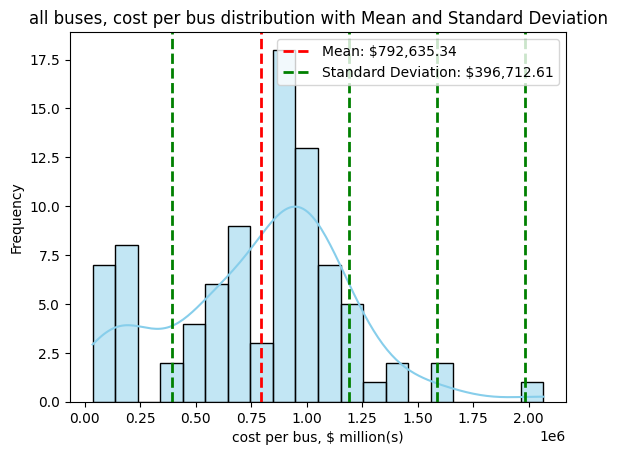

In [38]:
# chart of all cost per bus in the analysis.

dist_curve(
    df=merged_data,
    mean=cpb_mean,
    std=cpb_std,
    title="all buses, cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)

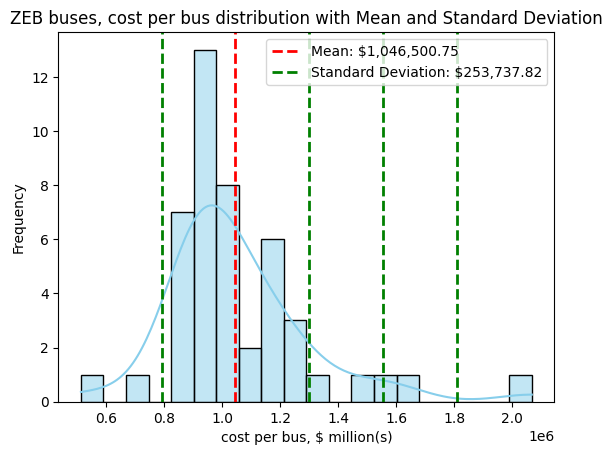

In [39]:
# ZEB cost per bus 
dist_curve(
    df=zeb_projects,
    #using the accounting, weighted average approach to mean (total cost/total number of buses)
    mean=zeb_cpb_wt_avg,
    # need to investigate if std needs to be weighted as well?
    std=zeb_projects["cost_per_bus"].std(),
    title="ZEB buses, cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)

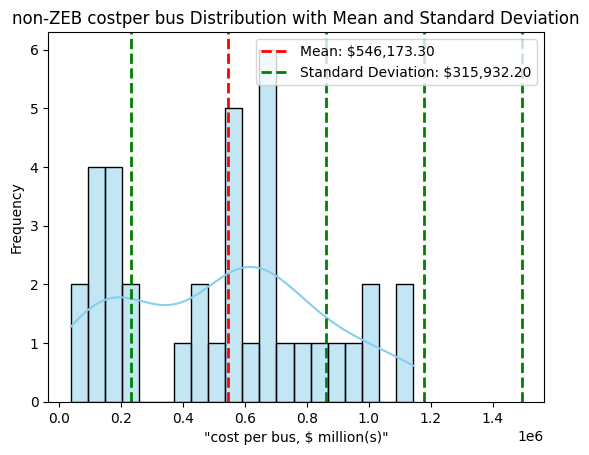

In [40]:
# non-zeb cost per bus
dist_curve(
    df=non_zeb_projects,
    mean=non_zeb_cpb_wt_avg,
    std=non_zeb_projects["cost_per_bus"].std(),
    title="non-ZEB costper bus Distribution",
    xlabel='"cost per bus, $ million(s)"',
)

In [41]:
agg_bus_size

,bus_size_type,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
0,articulated,0,2,58237576,41.0,1420428,1.605005,False
1,cutaway,3,0,16694500,152.0,109832,-1.464878,False
2,not specified,40,6,509919038,881.0,578795,-0.366399,False
3,over-the-road,0,1,9516000,14.0,679714,-0.130011,False
4,standard/conventional (30ft-45ft),0,36,234253277,264.0,887323,0.356283,False


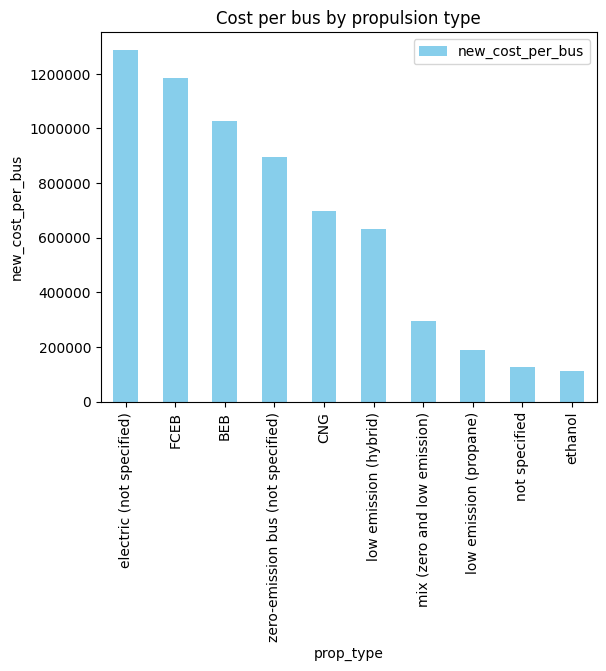

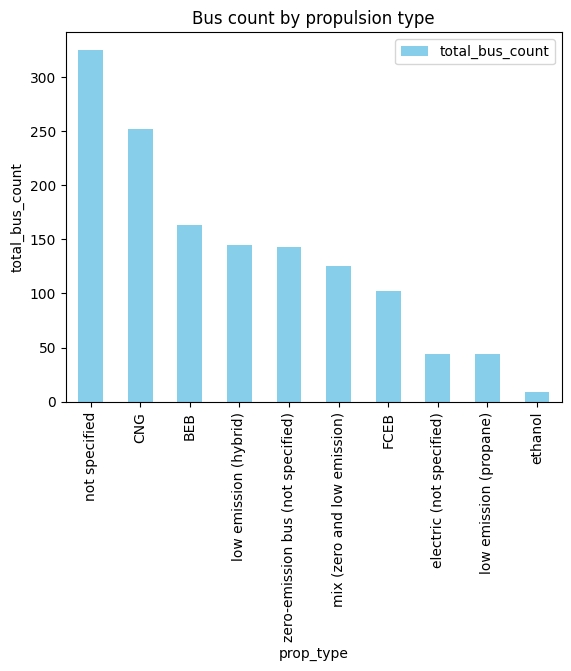

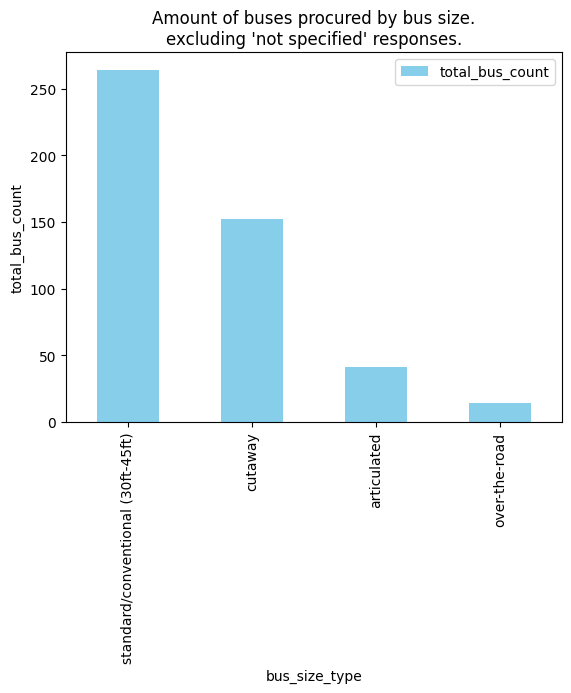

,prop_type,new_cost_per_bus,total_bus_count
3,electric (not specified),1288136,44.0
2,FCEB,1185797,102.0
0,BEB,1025966,163.0
9,zero-emission bus (not specified),896199,143.0
1,CNG,698568,252.0
5,low emission (hybrid),633271,145.0
7,mix (zero and low emission),294203,125.0
6,low emission (propane),190999,44.0
8,not specified,127853,325.0
4,ethanol,111861,9.0


In [42]:
# multiple bar charts in one cell

# cpb by prop type
make_chart("new_cost_per_bus", "Cost per bus by propulsion type", x_col="prop_type", data=agg_prop)

# bus count by prop type
make_chart("total_bus_count", "Bus count by propulsion type", x_col="prop_type", data=agg_prop)

#bus size bar chart
make_chart("total_bus_count", """Amount of buses procured by bus size.
excluding 'not specified' responses.""", x_col="bus_size_type",data=agg_bus_size[agg_bus_size["bus_size_type"]!="not specified"])

# pivot table to
agg_prop[["prop_type","new_cost_per_bus","total_bus_count"]].sort_values(by="new_cost_per_bus", ascending=False)


## Testing summary and conclusion
time to rework the summary section.

no more long expositions and variables. try to get the same point across using tables instead.

In [53]:
summary = f"""

# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type and bus sizes.

Data was compiled from three data sources:
1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. TIRCP project data (state-funded, California only)
3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc.. 

The initial dataset contained close to 300 projects, but was paired down due to projects including components other than buses. Examples include: projects that constructed new facilities, trainings or other non-bus related items like trains and sea farries were excluded.
The resulting dataset only contained projects that were solely used to procure buses. 

{len(merged_data)} projects were determined to contain solely bus purchases. 
These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.


Breakdown of each data souce:
{pivot_source.to_markdown(index=False)}


**ZEB buses include:**
- zero-emission (not specified) 
- electric (not specified)
- battery electric 
- fuel cell electric

**Non-ZEB buses include:**
- CNG 
- ethanol 
- ow emission (hybrid, propane) 
- diesel 
- gas

Below are charts and tables that summarize the findings.




"""
from IPython.display import Markdown, display

display(Markdown(summary))



# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type and bus sizes.

Data was compiled from three data sources:
1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. TIRCP project data (state-funded, California only)
3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc.. 

The initial dataset contained close to 300 projects, but was paired down due to projects including components other than buses. Examples include: projects that constructed new facilities, trainings or other non-bus related items like trains and sea farries were excluded.
The resulting dataset only contained projects that were solely used to procure buses. 

88 projects were determined to contain solely bus purchases. 
These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.


Breakdown of each data souce:
| source      |   bus_count |   total_cost |   cost_per_bus |
|:------------|------------:|-------------:|---------------:|
| dgs         |         236 |    250112853 |        1059800 |
| fta         |         883 |    391257025 |         443099 |
| tircp       |         233 |    187250513 |         803650 |
| Grand Total |        1352 |    828620391 |         612884 |


**ZEB buses include:**
- zero-emission (not specified) 
- electric (not specified)
- battery electric 
- fuel cell electric

**Non-ZEB buses include:**
- CNG 
- ethanol 
- ow emission (hybrid, propane) 
- diesel 
- gas

Below are charts and tables that summarize the findings.






In [48]:
display(
    Markdown("**ZEB Summary**"),
    pivot_zeb_prop,
    
    Markdown("**Non-ZEB Summary**"),
    pivot_non_zeb_prop,
    
    Markdown("The remaining buses did not specify a propulsion type")
)

**ZEB Summary**

,prop_type,bus_count,total_cost,cost_per_bus
0,BEB,163.0,167232489,1025966
1,FCEB,102.0,120951335,1185797
2,electric (not specified),44.0,56678000,1288136
3,zero-emission bus (not specified),143.0,128156513,896199
4,Grand Total,452.0,473018337,1046500


**Non-ZEB Summary**

,prop_type,bus_count,total_cost,cost_per_bus
0,CNG,252.0,176039140,698568
1,ethanol,9.0,1006750,111861
2,low emission (hybrid),145.0,91824361,633271
3,low emission (propane),44.0,8403969,190999
4,mix (zero and low emission),125.0,36775430,294203
5,Grand Total,575.0,314049650,546173


The remaining buses did not specify a propulsion type

In [44]:
#min max values for all projects
bus_min_max_summary(data=agg_agency,col1="new_cost_per_bus")
bus_min_max_summary(data=agg_agency,col1="total_bus_count")
bus_min_max_summary(data=agg_agency,col1="total_agg_cost")


**Max new_cost_per_bus**

,transit_agency,total_agg_cost,total_bus_count,new_cost_per_bus
71,Transit Joint Powers Authority for Merced County,3223324,2.0,1611662


**Min new_cost_per_bus**

,transit_agency,total_agg_cost,total_bus_count,new_cost_per_bus
45,Oregon Department of Transportation on behalf ...,181250,5.0,36250


**Max total_bus_count**

,transit_agency,total_agg_cost,total_bus_count,new_cost_per_bus
61,South Carolina Department of Transportation on...,15423904,160.0,96399


**Min total_bus_count**

,transit_agency,total_agg_cost,total_bus_count,new_cost_per_bus
9,City of Beloit,653184,1.0,653184
16,City of San Luis Obispo,859270,1.0,859270
49,"SLO TRANSIT (SAN LUIS OBISPO, CA)",847214,1.0,847214


**Max total_agg_cost**

,transit_agency,total_agg_cost,total_bus_count,new_cost_per_bus
24,Dallas Area Rapid Transit (DART),103000000,90.0,1144444


**Min total_agg_cost**

,transit_agency,total_agg_cost,total_bus_count,new_cost_per_bus
45,Oregon Department of Transportation on behalf ...,181250,5.0,36250


In [45]:
## min max values of just ZEB projects
# YES I CAN!!
new_cols =[
    "transit_agency",
    "prop_type",
    "total_cost",
    "bus_count",
    "cost_per_bus"]

display(Markdown("**Which Agneices had the highest and lowest cost per bus?**")),
bus_min_max_summary(data=zeb_projects, col1="cost_per_bus", col_list=new_cols)



**Which Agneices had the highest and lowest cost per bus?**

**Max cost_per_bus**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
76,University of California - San Diego,BEB,4134000,2.0,2067000


**Min cost_per_bus**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
45,City of Wasco,zero-emission bus (not specified),1543000,3.0,514333


In [46]:
display(Markdown(
    "**Which agency procured the most and least amount of ZEBs?**"
))
bus_min_max_summary(data=zeb_projects, col1="bus_count", col_list=new_cols)



**Which agency procured the most and least amount of ZEBs?**

**Max bus_count**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
44,City of Los Angeles (LA DOT),zero-emission bus (not specified),102790000,112.0,917767


**Min bus_count**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
70,"SLO TRANSIT (SAN LUIS OBISPO, CA)",BEB,847214,1.0,847214
82,City of San Luis Obispo,BEB,859270,1.0,859270


In [47]:
display(Markdown(
    "**Which Agency had the most and least total ZEB cost?**"
))
bus_min_max_summary(data=zeb_projects, col1="total_cost", col_list=new_cols)

**Which Agency had the most and least total ZEB cost?**

**Max total_cost**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
44,City of Los Angeles (LA DOT),zero-emission bus (not specified),102790000,112.0,917767


**Min total_cost**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
70,"SLO TRANSIT (SAN LUIS OBISPO, CA)",BEB,847214,1.0,847214


## conslusion

In [49]:
conclusion = f"""
**Conclusion**

Based on these findings, The average cost of a ZEB, throughout the US, is ~$1,000,000, roughly twice the price of a conventional, non-ZEB.
The variance in cost depends mainly on the options the Trasnit
Agencies chooses. Highly optioned/customized buses contribute to high cost.
Unfortunately, analyzing the cost of configuable options is outside the scope of data provided. 
"""
display(
    Markdown(conclusion)
)


**Conclusion**

Based on these findings, The average cost of a ZEB, throughout the US, is ~$1,000,000, roughly twice the price of a conventional, non-ZEB.
The variance in cost depends mainly on the options the Trasnit
Agencies chooses. Highly optioned/customized buses contribute to high cost.
Unfortunately, analyzing the cost of configuable options is outside the scope of data provided. 
